# Compare ROMS output to zeespiegelmonitor, reanalysis, AVISO altimetry


# Sea Level budget data

Ocean dynamic sea level is obtained from LocSteric and Wind

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import xesmf as xe

import matplotlib.pyplot as plt

In [2]:
# Import ROMS output

run3 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/run3/annual/NorthSea4_avg_annual.nc')
run4 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/run4/annual/NorthSea4_avg_annual.nc')

In [3]:
# Import zeespiegel budget data

slbudget_2021 = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/budget/slbudget_2021_12_13_NS_Fred16_1950_2020_ERA5_StericIAP_1100m.csv',
                           index_col = 'time')
slbudget_2022 = pd.read_csv('/Users/iriskeizer/Documents/ROMS/data/budget/slbudget_2022_06_14_ZSM_1950_2020_ERA5_StericIAP_2000m.csv',
                           index_col = 'time')

<AxesSubplot:xlabel='time'>

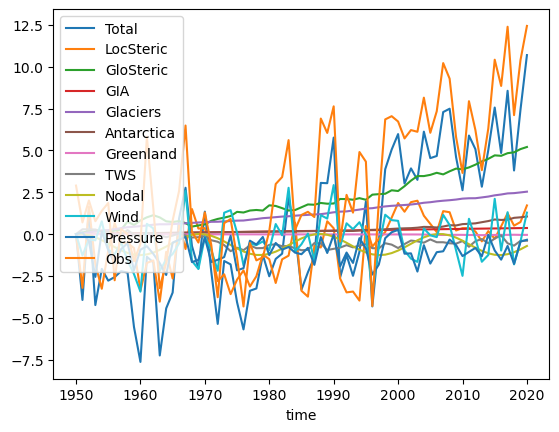

In [4]:
slbudget_2021.plot()

<AxesSubplot:xlabel='time'>

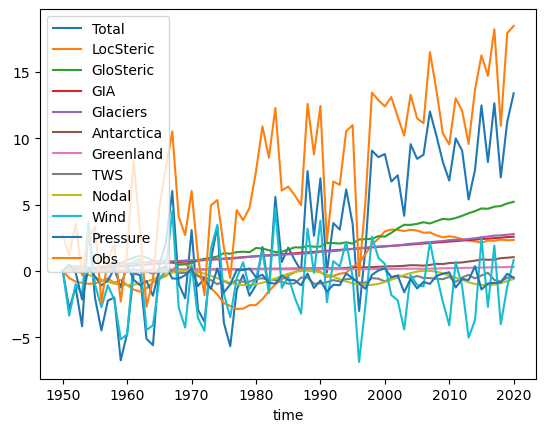

In [5]:
slbudget_2022.plot()

In [6]:
slbudget_2021

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1950,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.902359
1951,-3.931027,-3.211249,0.097124,0.00525,0.048333,0.005000,-0.001250,0.290417,0.008253,-1.269401,0.096495,0.702359
1952,1.461333,1.655393,0.176444,0.01050,0.107500,0.010417,-0.002083,0.284167,-0.054336,-0.312677,-0.413991,2.012359
1953,-4.235963,-1.791659,0.177486,0.01575,0.172083,0.015000,-0.001667,0.276667,-0.180699,-0.367838,-2.551085,0.772359
1954,-2.075711,-3.262929,0.193522,0.02100,0.222917,0.020417,-0.002500,0.165833,-0.356571,0.766438,0.156163,1.392359
...,...,...,...,...,...,...,...,...,...,...,...,...
2016,4.848630,0.470808,4.680546,0.34650,2.369583,0.850000,-0.042917,-0.073750,-1.249658,-0.979608,-1.522873,8.854070
2017,8.565807,1.251596,4.838131,0.35175,2.434167,0.865000,-0.042500,-0.545000,-1.196393,1.311972,-0.702915,12.391570
2018,3.803594,0.508159,4.889651,0.35700,2.451250,0.975000,-0.035000,-0.685417,-1.077951,-1.806060,-1.773038,7.110848


In [7]:
# Import AVISO altimetry data
aviso_altimetry = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/l4_duacs_0.25deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1659969934244.nc')

# Import CNES mdt data
cnes_mdt = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CNES MDT/dataset-mdt-cnes-cls18-global_1660042875042.nc')

In [8]:
# Obtain annual AVISO values
aviso_altimetry = aviso_altimetry.resample(time='1Y').mean()

# Only use ROMS domain
aviso_altimetry = aviso_altimetry.where((aviso_altimetry.latitude > 36) & (aviso_altimetry.latitude < 62) & (aviso_altimetry.longitude > -20 ) & (aviso_altimetry.longitude < 10) , drop = True) # Select region
cnes_mdt = cnes_mdt.where((cnes_mdt.latitude > 36) & (cnes_mdt.latitude < 62) & (cnes_mdt.longitude > -20 ) & (cnes_mdt.longitude < 10) , drop = True) # Select region


In [9]:
# Import reanalyis data
ora20c = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ORA20C/forcing input/ora20c.nc')


In [10]:
# Sort coordinates in increasing order
ora20c = ora20c.sortby(['time', 'latitude', 'longitude'])

# Remove years before 1950
ora20c = ora20c.where(ora20c.time.dt.year > 1949, drop = True)

# Only use ROMS domain
ora20c = ora20c.where((ora20c.latitude > 36) & (ora20c.latitude < 62) & (ora20c.longitude > -20 ) & (ora20c.longitude < 10) , drop = True) # Select region

# Obtain monthly and yearly averages
ora20c = ora20c.resample(time='1Y').mean()

## Change ROMS output to (latitude, longitude) grid and regrid ORA and AVISO data to the ROMS grid

In [11]:
# Create new dataset of sea level, temperature and salinity with dimensions s_rho, lat and lon

data_vars = dict(zeta=(["time", "latitude", "longitude"], run3.zeta.values),)

coords = dict(time=(["time"], run3.ocean_time.values),
             latitude=(["latitude"], run3.lat_rho.values[:,0]),
             longitude=(["longitude"], run3.lon_rho.values[0]))



run3 = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )

data_vars = dict(zeta=(["time", "latitude", "longitude"], run4.zeta.values),)

coords = dict(time=(["time"], run4.ocean_time.values),
             latitude=(["latitude"], run4.lat_rho.values[:,0]),
             longitude=(["longitude"], run4.lon_rho.values[0]))



run4 = xr.Dataset(data_vars=data_vars,
                           coords=coords,
                           )



In [12]:
# Sort coordinates in increasing order
aviso_altimetry = aviso_altimetry.sortby(['latitude', 'longitude'])
ora20c = ora20c.sortby(['latitude', 'longitude'])
cnes_mdt = cnes_mdt.sortby(['latitude', 'longitude'])


# Transpose dimensions
ora20c['zos'] = ora20c['zos'].transpose('time', 'latitude', 'longitude')
aviso_altimetry = aviso_altimetry.transpose('time', 'latitude', 'longitude')
cnes_mdt = cnes_mdt.transpose('time', 'latitude', 'longitude')




In [13]:
# Make arrays C_CONTIGUOUS
run3['zeta'] = run3['zeta'].astype(dtype = 'float32', order = 'C')
run4['zeta'] = run4['zeta'].astype(dtype = 'float32', order = 'C')
ora20c['zos'] = ora20c['zos'].astype(dtype = 'float32', order = 'C')
aviso_altimetry['adt'] = aviso_altimetry['adt'].astype(dtype = 'float64', order = 'C')
cnes_mdt['mdt'] = cnes_mdt['mdt'].astype(dtype = 'float64', order = 'C')


In [15]:
# Add mask
ora20c['mask'] = xr.where(~np.isnan(ora20c.zos.isel(time=0)), 1, 0)
aviso_altimetry['mask'] = xr.where(~np.isnan(aviso_altimetry.adt.isel(time=0)), 1, 0)
cnes_mdt['mask'] = xr.where(~np.isnan(cnes_mdt.mdt.isel(time=0)), 1, 0)
run3['mask'] = xr.where(~np.isnan(run3.zeta.isel(time=0)), 1, 0)


# Build regridder
regridder_ora = xe.Regridder(ora20c, run3, "bilinear", extrap_method= 'nearest_s2d')
regridder_aviso = xe.Regridder(aviso_altimetry, run3, "bilinear", extrap_method= 'nearest_s2d')
regridder_cnes = xe.Regridder(cnes_mdt, run3, "bilinear", extrap_method= 'nearest_s2d')




# Apply to data
ora20c4 = regridder_ora(ora20c)
aviso_altimetry4 = regridder_aviso(aviso_altimetry)
cnes_mdt4 = regridder_cnes(cnes_mdt)




## Compare ORA-reanalysis and AVISO altimetry annual regional mean

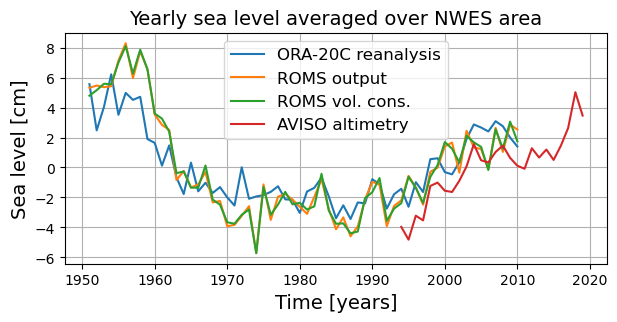

In [21]:
plt.figure(figsize = (7,3))

weights = np.cos(np.deg2rad(run3.latitude))


ora20c_weighted = ora20c4.weighted(weights)
run3_weighted = run3.weighted(weights)
run4_weighted = run4.weighted(weights)
aviso_weighted = aviso_altimetry4.weighted(weights)

ora_area = ora20c_weighted.mean(['latitude', 'longitude'])
run3_area = run3_weighted.mean(['latitude', 'longitude'])
run4_area = run4_weighted.mean(['latitude', 'longitude'])
aviso_area = aviso_weighted.mean(['latitude', 'longitude'])

# Substract time mean
ora_area = ora_area.zos - ora_area.zos.mean('time')
run3_area = run3_area.zeta - run3_area.zeta.mean('time')
run4_area = run4_area.zeta - run4_area.zeta.mean('time')
aviso_area = aviso_area.adt - aviso_area.adt.mean('time')

# Plot data
plt.plot(ora_area.time, ora_area*100)
plt.plot(run3_area.time, run3_area*100)
plt.plot(run4_area.time, run4_area*100)
plt.plot(aviso_area.time, aviso_area*100)

# Format figure
fsize = 14

plt.xlabel('Time [years]', fontsize = fsize)
plt.ylabel('Sea level [cm]', fontsize = fsize)
plt.title(f'Yearly sea level averaged over NWES area', fontsize = fsize)

#plt.ylim([-53, -35])
#plt.xlim([1950, 2020])
#plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
#plt.yticks([-50, -45, -40, -35], fontsize = fsize)

plt.grid()


# Add legend
plt.legend(labels = ['ORA-20C reanalysis', 'ROMS output', 'ROMS vol. cons.', 'AVISO altimetry'], fontsize = fsize-2)

plt.savefig('figures/roms_ora_aviso_region_average_weighted')

## Check ROMS output for tide gauge stations

In [31]:
# Import tide gauge locations

def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    path_slh = '/Users/iriskeizer/Documents/ROMS/data/'
    stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Brest', 'Sheerness', 'Cuxhaven']
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = path_slh + 'rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32, 1, 3, 7]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['station'] = stations
    df = df.set_index('station')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

tg_coords = station_coords()

In [39]:
# Import tide gauge locations

def station_coords_ns_fred16(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    path_slh = '/Users/iriskeizer/Documents/ROMS/data/'
    stations = ['Vlissingen','IJmuiden', 'West-Terschelling', 'Cuxhaven', 'Esbjerg', 'Hirsthals', 'Tregde', 'Stavanger', 'Lerwick', 'Aberdeen', 'North Shields', 'Lowestoft']
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = path_slh + 'rlr_annual/filelist.txt'
    loc_num = [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['station'] = stations
    df = df.set_index('station')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

tg_coords_ns_fred16 = station_coords_ns_fred16()

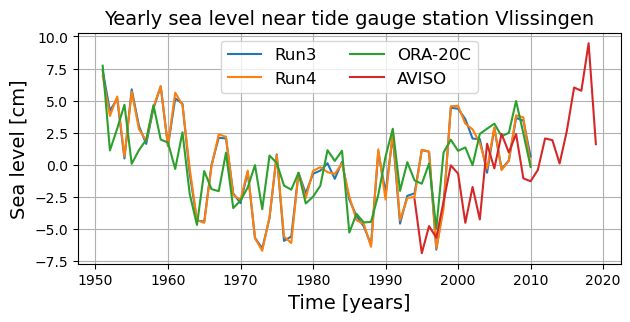

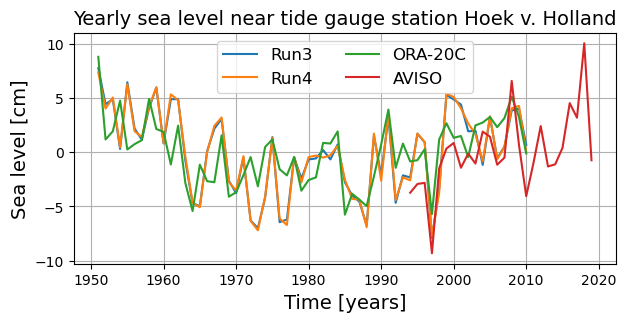

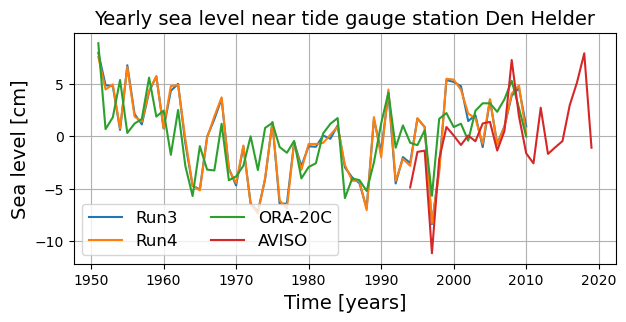

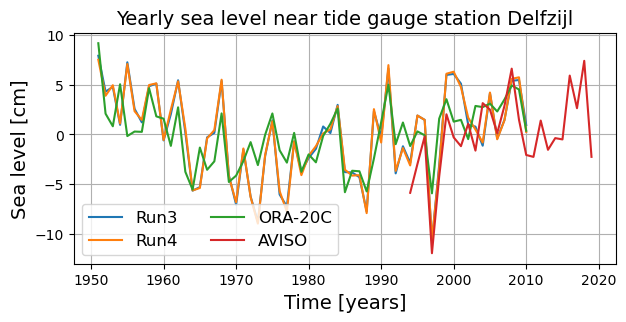

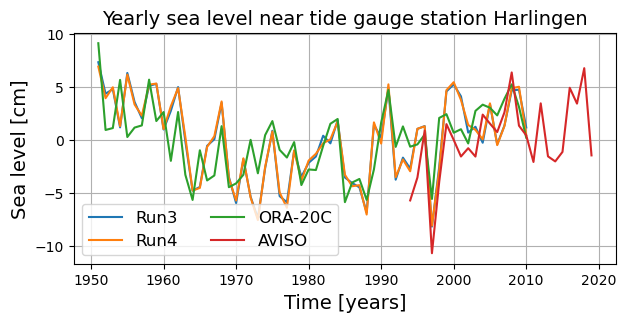

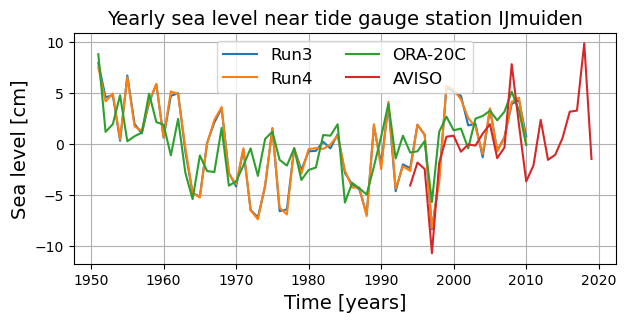

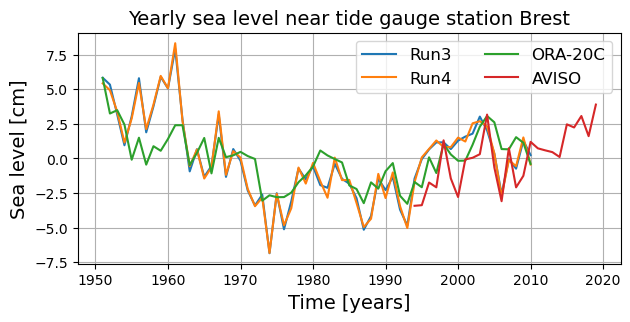

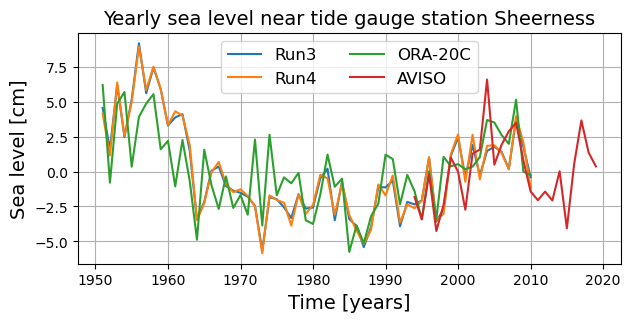

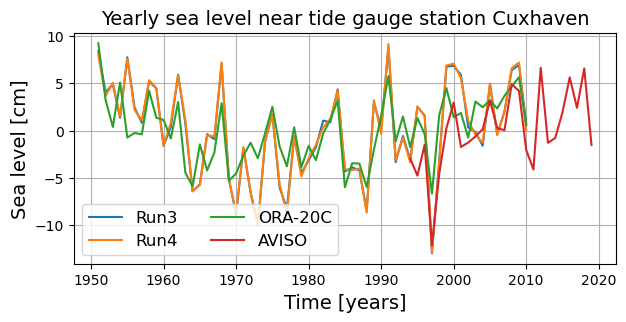

In [37]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Brest', 'Sheerness', 'Cuxhaven']

for station in stations:

    plt.figure(figsize = (7,3))
    
    
    # Select data near station
    if station == 'Vlissingen':
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
        
    elif station == 'Hoek v. Holland':
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
        
    elif station == 'Den Helder':
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
            
    elif station == 'Delfzijl': 
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
    
    elif station == 'Harlingen': 
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
           
    elif station == 'Brest': 
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station]-0.3, method = 'Nearest')
        
    
    elif station == 'Cuxhaven': 
        
        run3_station = run3.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station]+0.3, longitude = tg_coords['lon'][station], method = 'Nearest')
        
        
    else:
         
        run3_station = run3.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        run4_station = run4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        ora_station = ora20c4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
        aviso_station = aviso_altimetry4.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest')
    
    
   # Substract time mean
    run3_station = run3_station - run3_station.mean('time')
    run4_station = run4_station - run4_station.mean('time')
    ora_station = ora_station - ora_station.mean('time')
    aviso_station = aviso_station - aviso_station.mean('time')
    
    
    # Plot data
    plt.plot(run3_station.time, run3_station.zeta*100)
    plt.plot(run4_station.time, run4_station.zeta*100)
    plt.plot(ora_station.time, ora_station.zos*100)
    plt.plot(aviso_station.time, aviso_station.adt*100)

    # Format figure
    fsize = 14

    plt.xlabel('Time [years]', fontsize = fsize)
    plt.ylabel('Sea level [cm]', fontsize = fsize)
    plt.title(f'Yearly sea level near tide gauge station {station}', fontsize = fsize)

    #plt.xlim([1950, 2020])
    #plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
    #plt.yticks([-40, -20], fontsize = fsize)

    plt.grid()


    # Add legend
    plt.legend(labels = ['Run3', 'Run4', 'ORA-20C', 'AVISO'], fontsize = fsize-2, ncol=2)
    
    '''
    if station == 'Hoek v. Holland':
        plt.savefig(f'figures/ora_roms_tidegauges_HoekvHolland')
    else:
        plt.savefig(f'figures/ora_roms_tidegauges_{station}')
    '''

## Compare MDT and variability over period 1993 - 2009

- Mean dynamic topography anomalies with respect to the area-weighted regional mean 
- Interannual sea level variability as the SD of detrended, annual mean sea level

In [91]:
# Obtain MDT


# Obtain period from 1993 to 2009 and obtain time average to get MDT
run3_mdt = run3.zeta.where((run3.time.dt.year > 1992), drop = True).mean('time')
ora20c_mdt = ora20c4.zos.where(ora20c4.time.dt.year > 1992, drop = True).mean('time')


# Obtain anomalies w.r.t. area-weighted regional mean

# Obtain weights
weights = np.cos(np.deg2rad(run3_mdt.latitude))

# Obtain weighted datasets
run3_weighted = run3_mdt.weighted(weights)
ora20c_weighted = ora20c_mdt.weighted(weights)
cnes_weighted = cnes_mdt4.weighted(weights)

# Obtain area mean
run3_mdt_area_mean = run3_weighted.mean(['latitude', 'longitude'])
ora20c_mdt_area_mean = ora20c_weighted.mean(['latitude', 'longitude'])
cnes_mdt_area_mean = cnes_weighted.mean(['latitude', 'longitude'])

# Obtain anomalies
run3_mdt_anomaly = run3_mdt - run3_mdt_area_mean
ora20c_mdt_anomaly = ora20c_mdt - ora20c_mdt_area_mean
cnes_mdt_anomaly = cnes_mdt4.mdt - cnes_mdt_area_mean.mdt

# Convert to cm
run3_mdt_anomaly = run3_mdt_anomaly*100
ora20c_mdt_anomaly = ora20c_mdt_anomaly*100
cnes_mdt_anomaly = cnes_mdt_anomaly*100


In [96]:
aviso_altimetry4

<xarray.Dataset>
Dimensions:    (time: 26, latitude: 110, longitude: 122)
Coordinates:
  * time       (time) datetime64[ns] 1993-12-31 1994-12-31 ... 2018-12-31
  * latitude   (latitude) float64 35.95 36.25 36.56 36.86 ... 61.56 61.74 61.91
  * longitude  (longitude) float64 -19.88 -19.63 -19.39 ... 9.385 9.631 9.877
Data variables:
    adt        (time, latitude, longitude) float64 0.09668 0.0951 ... nan nan
    crs        (time, latitude, longitude) float64 -2.147e+09 -2.147e+09 ... nan
    mask       (latitude, longitude) int64 1 1 ... -9223372036854775808
Attributes:
    regrid_method:  bilinear

In [110]:
# Obtain variability 

# Obtain period from 1993 to 2009
run3_sd = run3.where((run3.time.dt.year > 1992), drop = True)
ora20c_sd = ora20c4.where(ora20c4.time.dt.year > 1992, drop = True)
aviso_sd = aviso_altimetry4.where(aviso_altimetry4.time.dt.year < 2010, drop = True)


# Obtain detrended data
run3_sd = run3_sd.zeta - xr.polyval(run3_sd.time, run3_sd.zeta.polyfit(dim = 'time', deg=3).polyfit_coefficients)
ora20c_sd = ora20c_sd.zos - xr.polyval(ora20c_sd.time, ora20c_sd.zos.polyfit(dim = 'time', deg=3).polyfit_coefficients)
aviso_sd = aviso_sd.adt - xr.polyval(aviso_sd.time, aviso_sd.adt.polyfit(dim = 'time', deg=3).polyfit_coefficients)


# Obtain standard deviation
run3_sd = run3_sd.std(dim = ['time'])*100
ora20c_sd = ora20c_sd.std(dim = ['time'])*100
aviso_sd = aviso_sd.std(dim = ['time'])*100



/Users/iriskeizer/opt/anaconda3/envs/esmf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/iriskeizer/opt/anaconda3/envs/esmf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/iriskeizer/opt/anaconda3/envs/esmf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


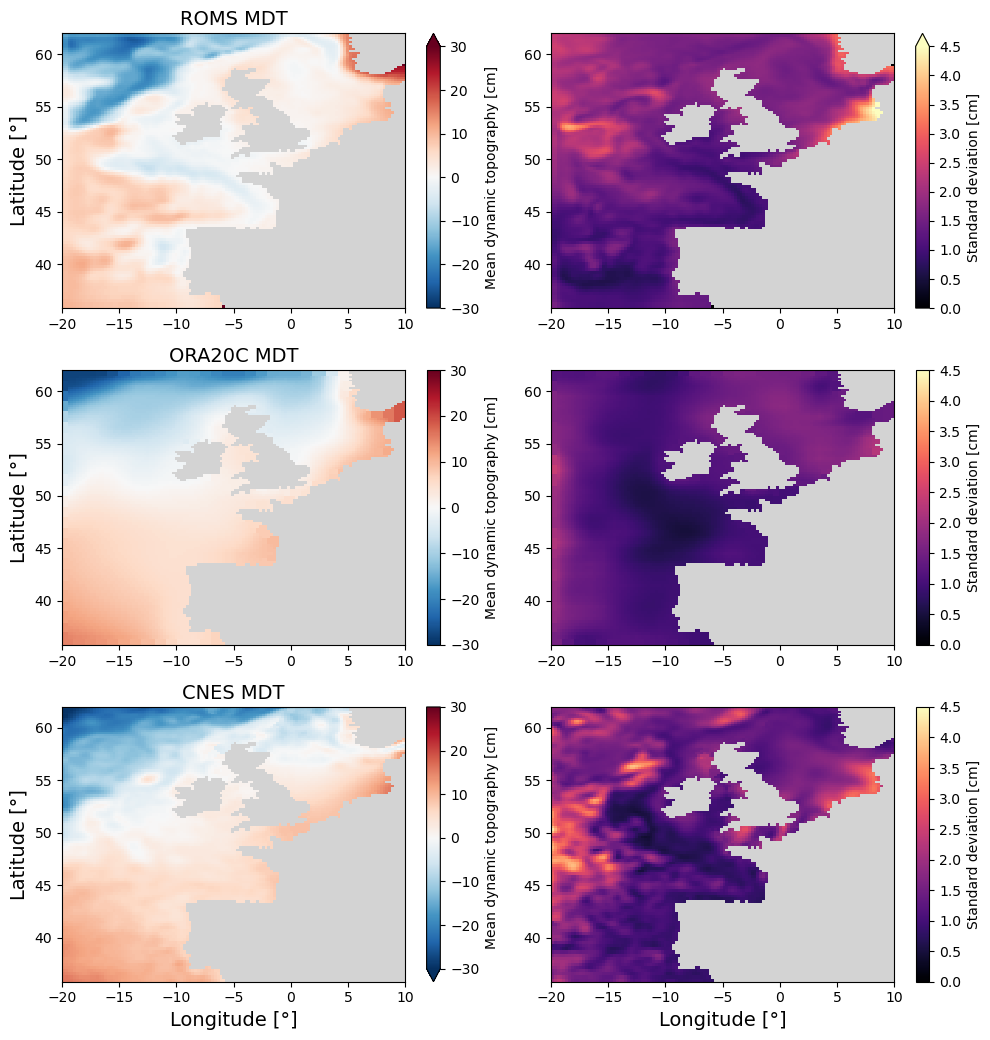

In [111]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (10, 3.5*3))

fsize = 14

# Plot MDT
run3_mdt_anomaly.plot(ax = axes[0,0], vmin = -30, vmax = 30, cmap = 'RdBu_r', cbar_kwargs={"label": "Mean dynamic topography [cm]"})
ora20c_mdt_anomaly.plot(ax = axes[1,0], vmin = -30, vmax = 30, cmap = 'RdBu_r', cbar_kwargs={"label": "Mean dynamic topography [cm]"})
cnes_mdt_anomaly.plot(ax = axes[2,0], vmin = -30, vmax = 30, cmap = 'RdBu_r', cbar_kwargs={"label": "Mean dynamic topography [cm]"})

# Plot SD
run3_sd.plot(ax = axes[0,1], vmin = 0, vmax = 4.5, cmap = 'magma', cbar_kwargs={"label": "Standard deviation [cm]"})
ora20c_sd.plot(ax = axes[1,1], vmin = 0, vmax = 4.5, cmap = 'magma', cbar_kwargs={"label": "Standard deviation [cm]"})
aviso_sd.plot(ax = axes[2,1], vmin = 0, vmax = 4.5, cmap = 'magma', cbar_kwargs={"label": "Standard deviation [cm]"})


# Add titles
axes[0,0].set_title('ROMS MDT', fontsize = fsize)
axes[1,0].set_title('ORA20C MDT', fontsize = fsize)
axes[2,0].set_title('CNES MDT', fontsize = fsize)



# Add y-labels
axes[0,0].set_ylabel('Latitude [°]', fontsize = fsize)
axes[1,0].set_ylabel('Latitude [°]', fontsize = fsize)
axes[2,0].set_ylabel('Latitude [°]', fontsize = fsize)

axes[0,1].set_ylabel('', fontsize = fsize)
axes[1,1].set_ylabel('', fontsize = fsize)
axes[2,1].set_ylabel('', fontsize = fsize)


# Add x-labels
axes[0,0].set_xlabel('', fontsize = fsize)
axes[1,0].set_xlabel('', fontsize = fsize)
axes[2,0].set_xlabel('Longitude [°]', fontsize = fsize)

axes[0,1].set_xlabel('', fontsize = fsize)
axes[1,1].set_xlabel('', fontsize = fsize)
axes[2,1].set_xlabel('Longitude [°]', fontsize = fsize)



# Change facecolor
axes[0,0].set_facecolor('lightgray')
axes[1,0].set_facecolor('lightgray')
axes[2,0].set_facecolor('lightgray')

axes[0,1].set_facecolor('lightgray')
axes[1,1].set_facecolor('lightgray')
axes[2,1].set_facecolor('lightgray')





plt.tight_layout()

## Compare ocean dynamic sea level of ROMS and budget

In [39]:
# Import tide gauge data
def tg_data_ns_fred16():
    """
    Function to import the tide gauge data
    
    """
    
    # Stations
    stations = ['Vlissingen','IJmuiden', 'West-Terschelling', 'Cuxhaven', 'Esbjerg', 'Hirsthals', 'Tregde', 'Stavanger', 'Lerwick', 'Aberdeen', 'North Shields', 'Lowestoft']
    
    
    # Define paths to data
    path_tg = '/Users/iriskeizer/Documents/ROMS/data/rlr_annual'
    path_locations = '/Users/iriskeizer/Documents/ROMS/data/rlr_annual/filelist.txt'
    
    # Import tide gauge sea level data
    loc_num = [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754]
    col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
    filelist_df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    filelist_df = filelist_df.set_index('id')
    filelist_df = filelist_df.loc[loc_num, :]
    names_col = ('time', 'height', 'interpolated', 'flags')
    
    for i in range(len(loc_num)):
            tg_data = pd.read_csv(path_tg + '/data/' + str(loc_num[i]) + 
                                  '.rlrdata', sep=';', header=None, names=names_col)
            #tg_data = tg_data.drop(['interpolated', 'flags'], 1)
            tg_data = tg_data.set_index('time')
            
            # Data before 1890 is incorrect
            tg_data = tg_data[tg_data.index>=1950] 
            
            # Calculate anomalies over whole period
            tg_data.height = tg_data.height - tg_data.height.mean() 

            if i==0:
                tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, col_name=tg_data.height))
                tg_data_df = tg_data_df.set_index('time')
                tg_data_df.columns  = [str(loc_num[i])] 
            else:
                tg_data_df[str(loc_num[i])] = tg_data.height
            

    tg_data_df = tg_data_df.rename(columns={"20": stations[0], "32": stations[1], "236": stations[2], "7": stations[3], "80": stations[4],
                              "89": stations[5], "302": stations[6], "47": stations[7], "830": stations[8], "361": stations[9], "95": stations[10], "754": stations[11]})

    #tg_data_df = tg_data_df.interpolate(method='slinear') # Interpolate in case of any nan values (but there are not)
    tg_data_df['Average'] = tg_data_df.mean(axis=1) # Add column containing the average of the stations 
    tg_data_df = tg_data_df*0.1 # mm -> cm
    
    
    
    
    return tg_data_df
    
    
tg_data_ns_fred16 = tg_data_ns_fred16()      

In [40]:
tg_data_ns_fred16

,Vlissingen,IJmuiden,West-Terschelling,Cuxhaven,Esbjerg,Hirsthals,Tregde,Stavanger,Lerwick,Aberdeen,North Shields,Lowestoft,Average
time,,,,,,,,,,,,,
1950,-3.883099,-2.923944,-0.591549,-2.450725,473.427941,1263.052941,304.274648,444.983099,NaN,1651.663077,1570.236765,NaN,569.778915
1951,-3.683099,-4.123944,-2.691549,-6.050725,470.327941,1260.152941,302.074648,452.583099,NaN,1641.163077,1566.036765,NaN,567.578915
1952,-0.883099,-2.123944,2.308451,-1.450725,470.427941,1262.752941,300.574648,449.683099,NaN,1642.963077,1564.636765,NaN,568.888915
1953,-5.883099,-7.323944,-0.591549,-4.550725,469.327941,1262.352941,299.374648,453.483099,NaN,1643.463077,1566.836765,NaN,567.648915
1954,-3.983099,-5.123944,0.208451,-4.150725,473.127941,1259.752941,298.874648,454.183099,NaN,1646.363077,1563.436765,NaN,568.268915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,7.516901,6.876056,7.208451,7.049275,481.927941,1256.752941,301.874648,453.383099,NaN,NaN,1579.836765,-9532.915625,-543.048955
2017,9.116901,9.876056,10.908451,12.949275,487.027941,1264.052941,304.674648,456.783099,NaN,NaN,1581.736765,-9532.915625,-539.578955
2018,4.616901,3.076056,2.508451,0.349275,NaN,NaN,301.374648,453.483099,NaN,NaN,NaN,-9532.915625,-1252.501028
